<a href="https://colab.research.google.com/github/hasnanasa/AI-projects/blob/main/RFM_ClusteringMachine_Learnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")

# Approche RFM

Source : https://en.wikipedia.org/wiki/RFM_(market_research)

## 1. GÉNÉRATION DE DONNÉES SYNTHÉTIQUES

In [ ]:
# Date de référence pour le calcul de la récence
reference_date = datetime(2024, 1, 1)

# Génération de données de transactions
np.random.seed(42)
n_customers = 1000
n_transactions = 5000

# Génération des données clients
customer_ids = np.random.randint(1, n_customers + 1, n_transactions)
transaction_dates = pd.date_range(
    start=datetime(2022, 1, 1),
    end=datetime(2023, 12, 31),
    freq='D'
)
transaction_dates = np.random.choice(transaction_dates, n_transactions)

# Montants des transactions (distribution log-normale)
amounts = np.random.lognormal(mean=3, sigma=1, size=n_transactions)

# Création du DataFrame
df_transactions = pd.DataFrame({
    'customer_id': customer_ids,
    'transaction_date': transaction_dates,
    'amount': amounts
})

print(f"Dataset généré: {len(df_transactions)} transactions pour {len(df_transactions['customer_id'].unique())} clients")
print(f"Période: {df_transactions['transaction_date'].min()} à {df_transactions['transaction_date'].max()}")
print(f"Montant moyen: {df_transactions['amount'].mean():.2f}€")
print("\nAperçu des données:")
print(df_transactions.head())

Dataset généré: 5000 transactions pour 989 clients
Période: 2022-01-01 00:00:00 à 2023-12-31 00:00:00
Montant moyen: 32.95€

Aperçu des données:
   customer_id transaction_date     amount
0          103       2023-09-24  39.639272
1          436       2023-07-21  23.046630
2          861       2022-01-27  29.912240
3          271       2023-09-22  24.915922
4          107       2022-08-19  24.655864


## 2. CALCUL DES MÉTRIQUES RFM

Dans un premier temps, nous allons calculer les métriques RFM nécessaires pour effectuer le clustering. En Machine Learning, il s'agit la de "Feature Engineering"

In [ ]:
def calculate_rfm(df, reference_date):
    """
    Calcule les métriques RFM pour chaque client

    R (Recency): Nombre de jours depuis le dernier achat
    F (Frequency): Nombre total de transactions
    M (Monetary): Montant total dépensé
    """

    rfm_data = df.groupby('customer_id').agg({
        'transaction_date': lambda x: (reference_date - x.max()).days,  # Récence
        'amount': ['count', 'sum']  # Fréquence et montant total
    }).reset_index()

    # Aplatissement des colonnes multi-niveaux
    rfm_data.columns = ['customer_id', 'recency', 'frequency', 'monetary']

    return rfm_data

In [ ]:
# Calcul des métriques RFM
rfm_df = calculate_rfm(df_transactions, reference_date)

print(f"\n=== STATISTIQUES RFM ===")
print(rfm_df.describe())


=== STATISTIQUES RFM ===
       customer_id     recency   frequency     monetary
count   989.000000  989.000000  989.000000   989.000000
mean    500.661274  140.500506    5.055612   166.572654
std     288.974386  136.356980    2.325258   123.385772
min       1.000000    1.000000    1.000000     1.938813
25%     251.000000   40.000000    3.000000    80.032623
50%     500.000000  101.000000    5.000000   139.824353
75%     750.000000  197.000000    6.000000   229.773982
max    1000.000000  729.000000   14.000000  1326.242301


## 3. CRÉATION DES SCORES RFM

In [ ]:
def create_rfm_scores(df):
    """
    Crée des scores RFM de 1 à 5 (5 étant le meilleur)
    """
    df_scored = df.copy()

    # Score de récence (inversé car plus petit = meilleur)
    df_scored['R_score'] = pd.qcut(df['recency'], 5, labels=[5,4,3,2,1])

    # Score de fréquence
    df_scored['F_score'] = pd.qcut(df['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])

    # Score monétaire
    df_scored['M_score'] = pd.qcut(df['monetary'], 5, labels=[1,2,3,4,5])

    # Score RFM combiné
    df_scored['RFM_score'] = (df_scored['R_score'].astype(str) +
                             df_scored['F_score'].astype(str) +
                             df_scored['M_score'].astype(str))

    return df_scored

In [ ]:
rfm_scored = create_rfm_scores(rfm_df)
print(f"\n=== EXEMPLES DE SCORES RFM ===")
print(rfm_scored[['customer_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']].head(10))


=== EXEMPLES DE SCORES RFM ===
   customer_id  recency  frequency    monetary R_score F_score M_score  \
0            1      116          9  245.366620       3       5       4   
1            2       58          6  373.673081       4       3       5   
2            3      153          4   91.288063       2       2       2   
3            4       21          2   49.440504       5       1       1   
4            5      201          5  232.415110       2       3       4   
5            6      723          1    3.070440       1       1       1   
6            7       36          7  428.701410       4       4       5   
7            8       57          7  106.241119       4       4       2   
8            9      302          3   82.866840       1       1       2   
9           10       91          6  298.679582       3       3       5   

  RFM_score  
0       354  
1       435  
2       222  
3       511  
4       234  
5       111  
6       445  
7       442  
8       112  
9       335  

## 4. VISUALISATION DES DISTRIBUTIONS RFM

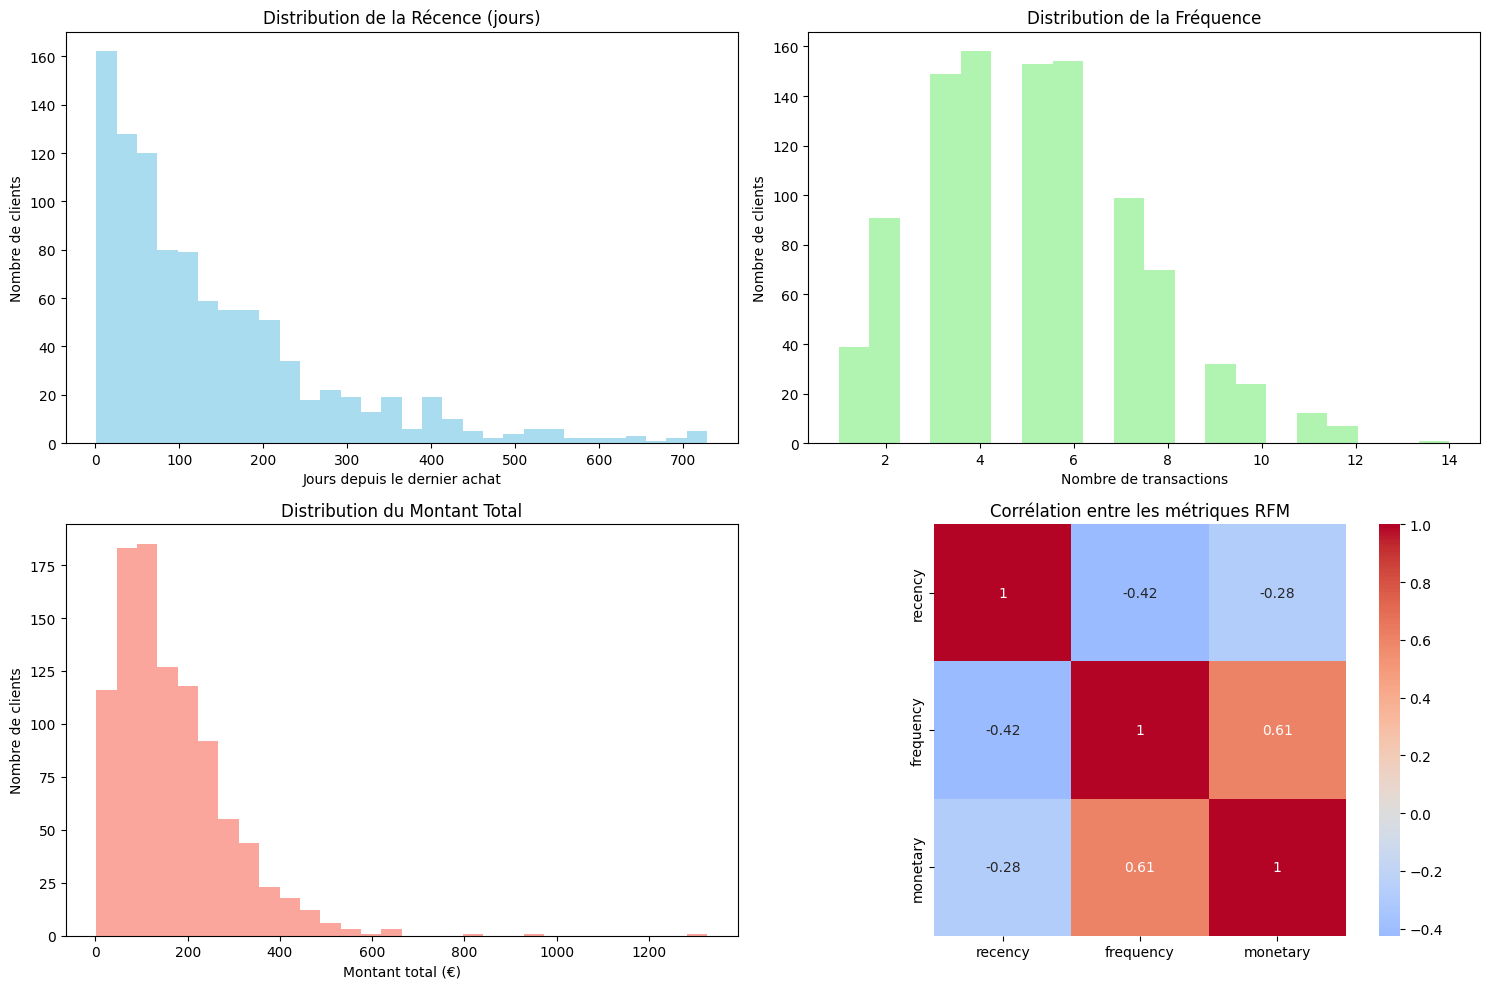

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution de la récence
axes[0,0].hist(rfm_df['recency'], bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution de la Récence (jours)')
axes[0,0].set_xlabel('Jours depuis le dernier achat')
axes[0,0].set_ylabel('Nombre de clients')

# Distribution de la fréquence
axes[0,1].hist(rfm_df['frequency'], bins=20, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Distribution de la Fréquence')
axes[0,1].set_xlabel('Nombre de transactions')
axes[0,1].set_ylabel('Nombre de clients')

# Distribution du montant
axes[1,0].hist(rfm_df['monetary'], bins=30, alpha=0.7, color='salmon')
axes[1,0].set_title('Distribution du Montant Total')
axes[1,0].set_xlabel('Montant total (€)')
axes[1,0].set_ylabel('Nombre de clients')

# Corrélation entre les métriques
correlation_matrix = rfm_df[['recency', 'frequency', 'monetary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            ax=axes[1,1], square=True)
axes[1,1].set_title('Corrélation entre les métriques RFM')

plt.tight_layout()
plt.show()

## 5. CLUSTERING K-MEANS

A présent, nous allons utiliser la méthode du coude (comme vue dans le livre sur le Machine Learning: https://www.machinelearnia.com/apprendre-le-machine-learning-en-une-semaine) afin de trouver le nombre de clustering idéal.

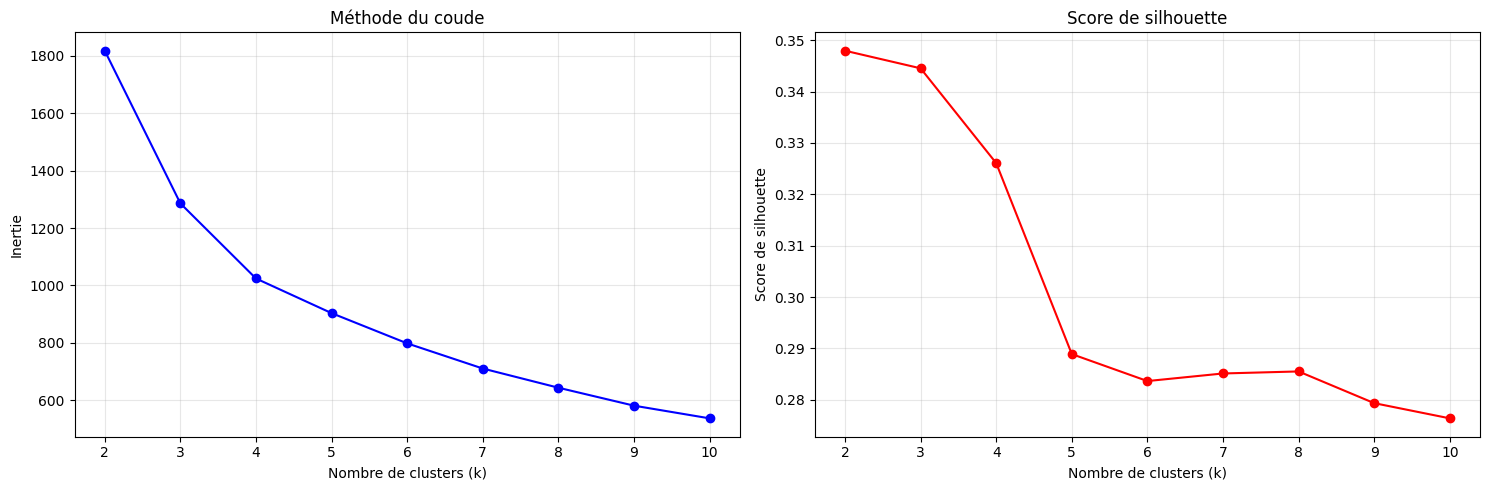


Nombre optimal de clusters: 2
Score de silhouette: 0.348

=== ANALYSE DES SEGMENTS ===
Statistiques par segment:
        recency         frequency       monetary         customer_id
           mean     std      mean   std     mean     std       count
cluster                                                             
0         80.48   72.81      6.83  1.79   246.80  123.25         487
1        198.73  156.92      3.34  1.24    88.74   54.40         502

Répartition des clients par segment:
Segment 0: 487 clients (49.2%)
Segment 1: 502 clients (50.8%)


In [ ]:
# Préparation des données pour le clustering
rfm_features = rfm_df[['recency', 'frequency', 'monetary']].copy()

# Normalisation des données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['recency_scaled', 'frequency_scaled', 'monetary_scaled'])

# Détermination du nombre optimal de clusters (méthode du coude)
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Visualisation pour choisir le nombre de clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Méthode du coude
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Nombre de clusters (k)')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode du coude')
ax1.grid(True, alpha=0.3)

# Score de silhouette
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Nombre de clusters (k)')
ax2.set_ylabel('Score de silhouette')
ax2.set_title('Score de silhouette')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sélection du nombre optimal de clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nNombre optimal de clusters: {optimal_k}")
print(f"Score de silhouette: {max(silhouette_scores):.3f}")

# Clustering final
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(rfm_scaled)

# Ajout des labels de cluster au DataFrame
rfm_df['cluster'] = cluster_labels

## 6. ANALYSE DES SEGMENTS

print(f"\n=== ANALYSE DES SEGMENTS ===")
segment_analysis = rfm_df.groupby('cluster').agg({
    'recency': ['mean', 'std'],
    'frequency': ['mean', 'std'],
    'monetary': ['mean', 'std'],
    'customer_id': 'count'
}).round(2)

print("Statistiques par segment:")
print(segment_analysis)

# Pourcentage de clients par segment
segment_sizes = rfm_df['cluster'].value_counts().sort_index()
segment_percentages = (segment_sizes / len(rfm_df) * 100).round(1)

print(f"\nRépartition des clients par segment:")
for cluster, percentage in segment_percentages.items():
    print(f"Segment {cluster}: {segment_sizes[cluster]} clients ({percentage}%)")

## 7. DÉFINITION DES PERSONAS CLIENT

In [ ]:
def define_customer_personas(df):
    """
    Définit des personas basés sur les caractéristiques RFM moyennes de chaque cluster
    """
    personas = {}

    for cluster in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster]
        avg_recency = cluster_data['recency'].mean()
        avg_frequency = cluster_data['frequency'].mean()
        avg_monetary = cluster_data['monetary'].mean()

        # Définition des personas basée sur les métriques
        if avg_recency <= 100 and avg_frequency >= 3 and avg_monetary >= 100:
            persona = "Champions"
        elif avg_recency <= 100 and avg_frequency >= 2:
            persona = "Clients Fidèles"
        elif avg_recency <= 200 and avg_monetary >= 100:
            persona = "Clients Potentiels"
        elif avg_recency > 200 and avg_frequency < 2:
            persona = "Clients Perdus"
        elif avg_frequency >= 3:
            persona = "Clients Récurrents"
        else:
            persona = "Nouveaux Clients"

        personas[cluster] = persona

    return personas

In [ ]:
personas = define_customer_personas(rfm_df)
rfm_df['persona'] = rfm_df['cluster'].map(personas)

print(f"\n=== PERSONAS CLIENT ===")
persona_summary = rfm_df.groupby('persona').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_id': 'count'
}).round(2)
persona_summary.columns = ['Récence_moy', 'Fréquence_moy', 'Montant_moy', 'Nb_clients']
print(persona_summary)


=== PERSONAS CLIENT ===
                    Récence_moy  Fréquence_moy  Montant_moy  Nb_clients
persona                                                                
Champions                 80.48           6.83       246.80         487
Clients Récurrents       198.73           3.34        88.74         502


## 8. VISUALISATIONS DES CLUSTERS

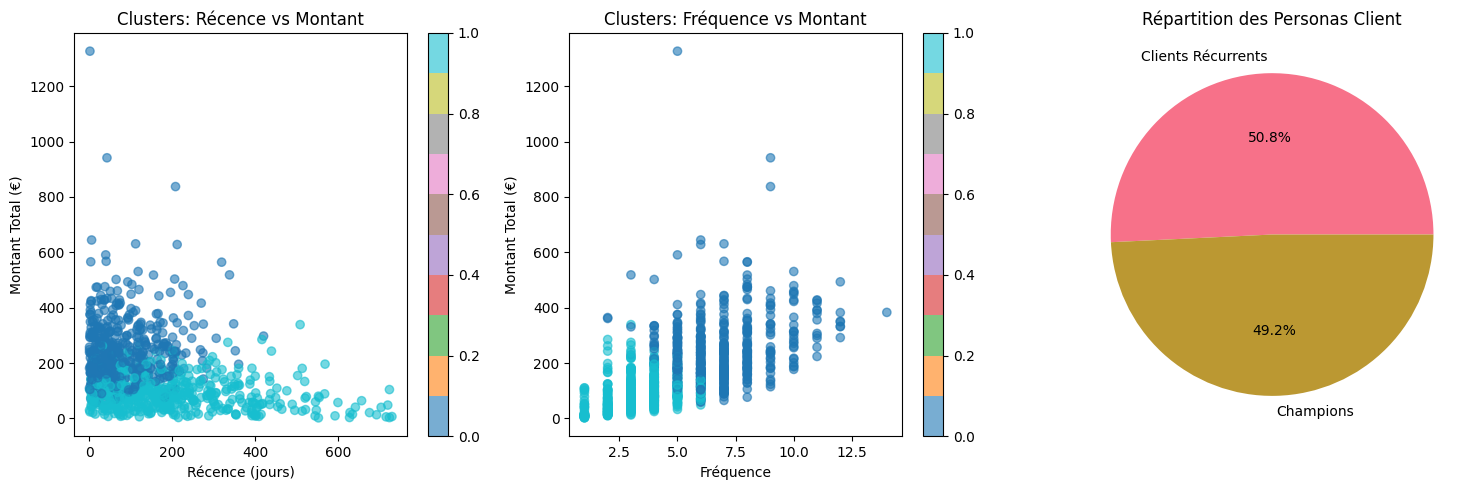

In [ ]:
# Graphique 3D des clusters
fig = plt.figure(figsize=(15, 5))

# Vue 2D: Récence vs Montant
ax1 = fig.add_subplot(131)
scatter = ax1.scatter(rfm_df['recency'], rfm_df['monetary'],
                     c=rfm_df['cluster'], cmap='tab10', alpha=0.6)
ax1.set_xlabel('Récence (jours)')
ax1.set_ylabel('Montant Total (€)')
ax1.set_title('Clusters: Récence vs Montant')
plt.colorbar(scatter, ax=ax1)

# Vue 2D: Fréquence vs Montant
ax2 = fig.add_subplot(132)
scatter = ax2.scatter(rfm_df['frequency'], rfm_df['monetary'],
                     c=rfm_df['cluster'], cmap='tab10', alpha=0.6)
ax2.set_xlabel('Fréquence')
ax2.set_ylabel('Montant Total (€)')
ax2.set_title('Clusters: Fréquence vs Montant')
plt.colorbar(scatter, ax=ax2)

# Répartition des personas
ax3 = fig.add_subplot(133)
persona_counts = rfm_df['persona'].value_counts()
ax3.pie(persona_counts.values, labels=persona_counts.index, autopct='%1.1f%%')
ax3.set_title('Répartition des Personas Client')

plt.tight_layout()
plt.show()


In [ ]:
## 9. RECOMMANDATIONS STRATÉGIQUES

print(f"\n=== RECOMMANDATIONS STRATÉGIQUES ===")

for persona in rfm_df['persona'].unique():
    persona_data = rfm_df[rfm_df['persona'] == persona]
    avg_recency = persona_data['recency'].mean()
    avg_frequency = persona_data['frequency'].mean()
    avg_monetary = persona_data['monetary'].mean()
    count = len(persona_data)

    print(f"\n{persona.upper()} ({count} clients):")
    print(f"  - Récence moyenne: {avg_recency:.0f} jours")
    print(f"  - Fréquence moyenne: {avg_frequency:.1f} transactions")
    print(f"  - Montant moyen: {avg_monetary:.2f}€")
        # Recommandations spécifiques
    if persona == "Champions":
        print("  🏆 Stratégie: Programmes VIP, produits exclusifs, ambassadeurs de marque")
    elif persona == "Clients Fidèles":
        print("  💎 Stratégie: Programmes de fidélité, upselling, récompenses")
    elif persona == "Clients Potentiels":
        print("  🎯 Stratégie: Offres personnalisées, campagnes de réactivation")
    elif persona == "Clients Perdus":
        print("  🔄 Stratégie: Campagnes de reconquête, offres de retour")
    elif persona == "Clients Récurrents":
        print("  🔁 Stratégie: Cross-selling, augmentation panier moyen")
    else:
        print("  🆕 Stratégie: Onboarding, offres de bienvenue, engagement")


=== RECOMMANDATIONS STRATÉGIQUES ===

CHAMPIONS (487 clients):
  - Récence moyenne: 80 jours
  - Fréquence moyenne: 6.8 transactions
  - Montant moyen: 246.80€
  🏆 Stratégie: Programmes VIP, produits exclusifs, ambassadeurs de marque

CLIENTS RÉCURRENTS (502 clients):
  - Récence moyenne: 199 jours
  - Fréquence moyenne: 3.3 transactions
  - Montant moyen: 88.74€
  🔁 Stratégie: Cross-selling, augmentation panier moyen


## 10. EXPORT DES RÉSULTATS

In [ ]:
# Sauvegarde des résultats
results_df = rfm_df[['customer_id', 'recency', 'frequency', 'monetary', 'cluster', 'persona']].copy()

print(f"\n=== RÉSUMÉ DE L'ANALYSE ===")
print(f"• {len(rfm_df)} clients analysés")
print(f"• {optimal_k} segments identifiés")
print(f"• {len(rfm_df['persona'].unique())} personas définis")
print(f"• Score de silhouette: {max(silhouette_scores):.3f}")

print(f"\nTop 10 des clients Champions:")
if 'Champions' in rfm_df['persona'].values:
    champions = rfm_df[rfm_df['persona'] == 'Champions'].nlargest(10, 'monetary')
    print(champions[['customer_id', 'recency', 'frequency', 'monetary']].to_string(index=False))
else:
    top_customers = rfm_df.nlargest(10, 'monetary')
    print(top_customers[['customer_id', 'recency', 'frequency', 'monetary', 'persona']].to_string(index=False))

print(f"\n✅ Analyse RFM terminée avec succès!")


=== RÉSUMÉ DE L'ANALYSE ===
• 989 clients analysés
• 2 segments identifiés
• 2 personas définis
• Score de silhouette: 0.348

Top 10 des clients Champions:
 customer_id  recency  frequency    monetary
         456        2          5 1326.242301
         947       43          9  941.209848
         349      208          9  837.275247
         911        6          6  644.306090
         751      112          7  630.550016
          65      212          6  627.991455
         440       40          5  590.613786
         414       41          7  567.394443
         524        4          8  565.696679
         759      319          8  564.329072

✅ Analyse RFM terminée avec succès!
